**M931 : Deep Learning for NLP |
Winter Semester 2023/24 |
Student ID: lt12200010 |
Student Name: Kleopatra Karapanagiotou**

**Assignment_3: SENTIMENT ANALYSIS OF TWEETS USING BIDIRECTIONAL RNN**

In this assignment we use bidirectional RNNs in order to predict the polarity ouf tweets in Greek language about the Greek general elections.
Bidirectional RNNs and especially LSTMs and GRUs come to solve the problem of handling sequences of various lenths in the input, as well as processing a piece of text both from left to right and from right to left, which helps in capturing the whole context of a sequence. Let's see if the RNNs managed to overcome the performance of our previous models (FFNN and Logistic Regression)

In [1]:
!pip install demoji optuna torchtext==0.6.0 accelerate -U
!python -m spacy download el_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 665.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.2
    Uninstalling torchtext-0.16.2:
      Successfully uninstalled torchtext-0.16.2
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.26.1
    Uninstalling accelerate-0.26.1:
      Successfully uninstalled accelerate-0.26.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 82.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')


#Imports

In [2]:
# Import necessary libraries
import re
import random
import shutil
import spacy
import string
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import math
import demoji
import time
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook
from numpy import interp
from itertools import cycle
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import collections
from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

import torchtext
from torchtext import data, datasets
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torchtext.vocab as vocab


import optuna
from optuna.trial import TrialState
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#GPU setup

In [3]:
# Set up GPU for Training
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 2 GPU(s) available.
Device name: Tesla T4


#Greek stemmer

In [4]:
__cases = dict()
__cases["ΦΑΓΙΑ"] = "ΦΑ"
__cases["ΦΑΓΙΟΥ"] = "ΦΑ"
__cases["ΦΑΓΙΩΝ"] = "ΦΑ"
__cases["ΣΚΑΓΙΑ"] = "ΣΚΑ"
__cases["ΣΚΑΓΙΟΥ"] = "ΣΚΑ"
__cases["ΣΚΑΓΙΩΝ"] = "ΣΚΑ"
__cases["ΟΛΟΓΙΟΥ"] = "ΟΛΟ"
__cases["ΟΛΟΓΙΑ"] = "ΟΛΟ"
__cases["ΟΛΟΓΙΩΝ"] = "ΟΛΟ"
__cases["ΣΟΓΙΟΥ"] = "ΣΟ"
__cases["ΣΟΓΙΑ"] = "ΣΟ"
__cases["ΣΟΓΙΩΝ"] = "ΣΟ"
__cases["ΤΑΤΟΓΙΑ"] = "ΤΑΤΟ"
__cases["ΤΑΤΟΓΙΟΥ"] = "ΤΑΤΟ"
__cases["ΤΑΤΟΓΙΩΝ"] = "ΤΑΤΟ"
__cases["ΚΡΕΑΣ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΟΣ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΑ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΩΝ"] = "ΚΡΕ"
__cases["ΠΕΡΑΣ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΟΣ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΑ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΩΝ"] = "ΠΕΡ"
__cases["ΤΕΡΑΣ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΟΣ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΑ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΩΝ"] = "ΤΕΡ"
__cases["ΦΩΣ"] = "ΦΩ"
__cases["ΦΩΤΟΣ"] = "ΦΩ"
__cases["ΦΩΤΑ"] = "ΦΩ"
__cases["ΦΩΤΩΝ"] = "ΦΩ"
__cases["ΚΑΘΕΣΤΩΣ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΟΣ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΑ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΩΝ"] = "ΚΑΘΕΣΤ"
__cases["ΓΕΓΟΝΟΣ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΟΣ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΑ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΩΝ"] = "ΓΕΓΟΝ"
__vowels = "[ΑΕΗΙΟΥΩ]"
__refinedVowels = "[ΑΕΗΙΟΩ]"


def stemWord(w: str, exceptions: dict = None):
    stem = None
    suffix = None
    test1 = True

    if exceptions is not None and w in exceptions.keys():
        return exceptions[w]

    if len(w) < 4:
        return w

    pattern = None
    pattern2 = None
    pattern3 = None
    pattern4 = None

    # Step1
    pattern = re.compile(
        r"(.*)(ΦΑΓΙΑ|ΦΑΓΙΟΥ|ΦΑΓΙΩΝ|ΣΚΑΓΙΑ|ΣΚΑΓΙΟΥ|ΣΚΑΓΙΩΝ|ΟΛΟΓΙΟΥ|ΟΛΟΓΙΑ|ΟΛΟΓΙΩΝ|ΣΟΓΙΟΥ|ΣΟΓΙΑ|ΣΟΓΙΩΝ|ΤΑΤΟΓΙΑ|ΤΑΤΟΓΙΟΥ|ΤΑΤΟΓΙΩΝ|ΚΡΕΑΣ|ΚΡΕΑΤΟΣ|ΚΡΕΑΤΑ|ΚΡΕΑΤΩΝ|ΠΕΡΑΣ|ΠΕΡΑΤΟΣ|ΠΕΡΑΤΑ|ΠΕΡΑΤΩΝ|ΤΕΡΑΣ|ΤΕΡΑΤΟΣ|ΤΕΡΑΤΑ|ΤΕΡΑΤΩΝ|ΦΩΣ|ΦΩΤΟΣ|ΦΩΤΑ|ΦΩΤΩΝ|ΚΑΘΕΣΤΩΣ|ΚΑΘΕΣΤΩΤΟΣ|ΚΑΘΕΣΤΩΤΑ|ΚΑΘΕΣΤΩΤΩΝ|ΓΕΓΟΝΟΣ|ΓΕΓΟΝΟΤΟΣ|ΓΕΓΟΝΟΤΑ|ΓΕΓΟΝΟΤΩΝ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        suffix = fp[1]
        w = stem + __cases[suffix]
        test1 = False

    # Step 2a
    pattern = re.compile(r"^(.+?)(ΑΔΕΣ|ΑΔΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        reg1 = re.compile(r"(ΟΚ|ΜΑΜ|ΜΑΝ|ΜΠΑΜΠ|ΠΑΤΕΡ|ΓΙΑΓΙ|ΝΤΑΝΤ|ΚΥΡ|ΘΕΙ|ΠΕΘΕΡ)$")

        if not reg1.match(w):
            w = w + "ΑΔ"

    # Step 2b
    pattern2 = re.compile(r"^(.+?)(ΕΔΕΣ|ΕΔΩΝ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        except2 = re.compile(r"(ΟΠ|ΙΠ|ΕΜΠ|ΥΠ|ΓΗΠ|ΔΑΠ|ΚΡΑΣΠ|ΜΙΛ)$")
        if except2.match(w):
            w = w + "ΕΔ"

    # Step 2c
    pattern3 = re.compile(r"^(.+?)(ΟΥΔΕΣ|ΟΥΔΩΝ)$")
    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        except3 = re.compile(r"(ΑΡΚ|ΚΑΛΙΑΚ|ΠΕΤΑΛ|ΛΙΧ|ΠΛΕΞ|ΣΚ|Σ|ΦΛ|ΦΡ|ΒΕΛ|ΛΟΥΛ|ΧΝ|ΣΠ|ΤΡΑΓ|ΦΕ)$")
        if except3.match(w):
            w = w + "ΟΥΔ"

    # Step 2d
    pattern4 = re.compile("^(.+?)(ΕΩΣ|ΕΩΝ)$")
    if pattern4.match(w):
        fp = pattern4.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except4 = re.compile(r"^(Θ|Δ|ΕΛ|ΓΑΛ|Ν|Π|ΙΔ|ΠΑΡ)$")
        if except4.match(w):
            w = w + "Ε"

    # Step 3
    pattern = re.compile(r"^(.+?)(ΙΑ|ΙΟΥ|ΙΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        pattern2 = re.compile(__vowels + "$")
        test1 = False
        if pattern2.match(w):
            w = stem + "Ι"

    # Step 4
    pattern = re.compile(r"^(.+?)(ΙΚΑ|ΙΚΟ|ΙΚΟΥ|ΙΚΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(__vowels + "$")
        except5 = re.compile(
            r"^(ΑΛ|ΑΔ|ΕΝΔ|ΑΜΑΝ|ΑΜΜΟΧΑΛ|ΗΘ|ΑΝΗΘ|ΑΝΤΙΔ|ΦΥΣ|ΒΡΩΜ|ΓΕΡ|ΕΞΩΔ|ΚΑΛΠ|ΚΑΛΛΙΝ|ΚΑΤΑΔ|ΜΟΥΛ|ΜΠΑΝ|ΜΠΑΓΙΑΤ|ΜΠΟΛ|ΜΠΟΣ|ΝΙΤ|ΞΙΚ|ΣΥΝΟΜΗΛ|ΠΕΤΣ|ΠΙΤΣ|ΠΙΚΑΝΤ|ΠΛΙΑΤΣ|ΠΟΣΤΕΛΝ|ΠΡΩΤΟΔ|ΣΕΡΤ|ΣΥΝΑΔ|ΤΣΑΜ|ΥΠΟΔ|ΦΙΛΟΝ|ΦΥΛΟΔ|ΧΑΣ)$")
        if except5.match(w) or pattern2.match(w):
            w = w + "ΙΚ"

    # step 5a
    pattern = re.compile(r"^(.+?)(ΑΜΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΑΓΑΜΕ|ΗΣΑΜΕ|ΟΥΣΑΜΕ|ΗΚΑΜΕ|ΗΘΗΚΑΜΕ)$")
    if w == "ΑΓΑΜΕ":
        w = "ΑΓΑΜ"

    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except6 = re.compile(r"^(ΑΝΑΠ|ΑΠΟΘ|ΑΠΟΚ|ΑΠΟΣΤ|ΒΟΥΒ|ΞΕΘ|ΟΥΛ|ΠΕΘ|ΠΙΚΡ|ΠΟΤ|ΣΙΧ|Χ)$")
        if except6.match(w):
            w = w + "ΑΜ"

    # Step 5b
    pattern2 = re.compile(r"^(.+?)(ΑΝΕ)$")
    pattern3 = re.compile(r"^(.+?)(ΑΓΑΝΕ|ΗΣΑΝΕ|ΟΥΣΑΝΕ|ΙΟΝΤΑΝΕ|ΙΟΤΑΝΕ|ΙΟΥΝΤΑΝΕ|ΟΝΤΑΝΕ|ΟΤΑΝΕ|ΟΥΝΤΑΝΕ|ΗΚΑΝΕ|ΗΘΗΚΑΝΕ)$")
    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern3 = re.compile(r"^(ΤΡ|ΤΣ)$")
        if pattern3.match(w):
            w = w + "ΑΓΑΝ"

    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(__refinedVowels + "$")
        except7 = re.compile(
            r"^(ΒΕΤΕΡ|ΒΟΥΛΚ|ΒΡΑΧΜ|Γ|ΔΡΑΔΟΥΜ|Θ|ΚΑΛΠΟΥΖ|ΚΑΣΤΕΛ|ΚΟΡΜΟΡ|ΛΑΟΠΛ|ΜΩΑΜΕΘ|Μ|ΜΟΥΣΟΥΛΜ|Ν|ΟΥΛ|Π|ΠΕΛΕΚ|ΠΛ|ΠΟΛΙΣ|ΠΟΡΤΟΛ|ΣΑΡΑΚΑΤΣ|ΣΟΥΛΤ|ΤΣΑΡΛΑΤ|ΟΡΦ|ΤΣΙΓΓ|ΤΣΟΠ|ΦΩΤΟΣΤΕΦ|Χ|ΨΥΧΟΠΛ|ΑΓ|ΟΡΦ|ΓΑΛ|ΓΕΡ|ΔΕΚ|ΔΙΠΛ|ΑΜΕΡΙΚΑΝ|ΟΥΡ|ΠΙΘ|ΠΟΥΡΙΤ|Σ|ΖΩΝΤ|ΙΚ|ΚΑΣΤ|ΚΟΠ|ΛΙΧ|ΛΟΥΘΗΡ|ΜΑΙΝΤ|ΜΕΛ|ΣΙΓ|ΣΠ|ΣΤΕΓ|ΤΡΑΓ|ΤΣΑΓ|Φ|ΕΡ|ΑΔΑΠ|ΑΘΙΓΓ|ΑΜΗΧ|ΑΝΙΚ|ΑΝΟΡΓ|ΑΠΗΓ|ΑΠΙΘ|ΑΤΣΙΓΓ|ΒΑΣ|ΒΑΣΚ|ΒΑΘΥΓΑΛ|ΒΙΟΜΗΧ|ΒΡΑΧΥΚ|ΔΙΑΤ|ΔΙΑΦ|ΕΝΟΡΓ|ΘΥΣ|ΚΑΠΝΟΒΙΟΜΗΧ|ΚΑΤΑΓΑΛ|ΚΛΙΒ|ΚΟΙΛΑΡΦ|ΛΙΒ|ΜΕΓΛΟΒΙΟΜΗΧ|ΜΙΚΡΟΒΙΟΜΗΧ|ΝΤΑΒ|ΞΗΡΟΚΛΙΒ|ΟΛΙΓΟΔΑΜ|ΟΛΟΓΑΛ|ΠΕΝΤΑΡΦ|ΠΕΡΗΦ|ΠΕΡΙΤΡ|ΠΛΑΤ|ΠΟΛΥΔΑΠ|ΠΟΛΥΜΗΧ|ΣΤΕΦ|ΤΑΒ|ΤΕΤ|ΥΠΕΡΗΦ|ΥΠΟΚΟΠ|ΧΑΜΗΛΟΔΑΠ|ΨΗΛΟΤΑΒ)$")
        if (pattern2.match(w)) or (except7.match(w)):
            w = w + "ΑΝ"

    # //Step 5c
    pattern3 = re.compile(r"^(.+?)(ΕΤΕ)$")
    pattern4 = re.compile(r"^(.+?)(ΗΣΕΤΕ)$")
    if pattern4.match(w):
        fp = pattern4.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern3 = re.compile(__refinedVowels + "$")
        except8 = re.compile(
            r"(ΟΔ|ΑΙΡ|ΦΟΡ|ΤΑΘ|ΔΙΑΘ|ΣΧ|ΕΝΔ|ΕΥΡ|ΤΙΘ|ΥΠΕΡΘ|ΡΑΘ|ΕΝΘ|ΡΟΘ|ΣΘ|ΠΥΡ|ΑΙΝ|ΣΥΝΔ|ΣΥΝ|ΣΥΝΘ|ΧΩΡ|ΠΟΝ|ΒΡ|ΚΑΘ|ΕΥΘ|ΕΚΘ|ΝΕΤ|ΡΟΝ|ΑΡΚ|ΒΑΡ|ΒΟΛ|ΩΦΕΛ)$")
        except9 = re.compile(
            r"^(ΑΒΑΡ|ΒΕΝ|ΕΝΑΡ|ΑΒΡ|ΑΔ|ΑΘ|ΑΝ|ΑΠΛ|ΒΑΡΟΝ|ΝΤΡ|ΣΚ|ΚΟΠ|ΜΠΟΡ|ΝΙΦ|ΠΑΓ|ΠΑΡΑΚΑΛ|ΣΕΡΠ|ΣΚΕΛ|ΣΥΡΦ|ΤΟΚ|Υ|Δ|ΕΜ|ΘΑΡΡ|Θ)$")
        if (pattern3.match(w)) or (except8.match(w)) or (except9.match(w)):
            w = w + "ΕΤ"

    # Step 5d
    pattern = re.compile(r"^(.+?)(ΟΝΤΑΣ|ΩΝΤΑΣ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except10 = re.compile(r"^(ΑΡΧ)$")
        except11 = re.compile(r"(ΚΡΕ)$")
        if except10.match(w):
            w = w + "ΟΝΤ"
        if except11.match(w):
            w = w + "ΩΝΤ"

    # Step 5e
    pattern = re.compile(r"^(.+?)(ΟΜΑΣΤΕ|ΙΟΜΑΣΤΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except11 = re.compile("^(ΟΝ)$")
        if except11.match(w):
            w = w + "ΟΜΑΣΤ"

    # Step 5f
    pattern = re.compile(r"^(.+?)(ΕΣΤΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΙΕΣΤΕ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(r"^(Π|ΑΠ|ΣΥΜΠ|ΑΣΥΜΠ|ΑΚΑΤΑΠ|ΑΜΕΤΑΜΦ)$")
        if pattern2.match(w):
            w = w + "ΙΕΣΤ"

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except12 = re.compile(r"^(ΑΛ|ΑΡ|ΕΚΤΕΛ|Ζ|Μ|Ξ|ΠΑΡΑΚΑΛ|ΑΡ|ΠΡΟ|ΝΙΣ)$")
        if except12.match(w):
            w = w + "ΕΣΤ"

    # Step 5g
    pattern = re.compile(r"^(.+?)(ΗΚΑ|ΗΚΕΣ|ΗΚΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΗΘΗΚΑ|ΗΘΗΚΕΣ|ΗΘΗΚΕ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except13 = re.compile(r"(ΣΚΩΛ|ΣΚΟΥΛ|ΝΑΡΘ|ΣΦ|ΟΘ|ΠΙΘ)$")
        except14 = re.compile(r"^(ΔΙΑΘ|Θ|ΠΑΡΑΚΑΤΑΘ|ΠΡΟΣΘ|ΣΥΝΘ|)$")
        if (except13.match(w)) or (except14.match(w)):
            w = w + "ΗΚ"

    # Step 5h
    pattern = re.compile(r"^(.+?)(ΟΥΣΑ|ΟΥΣΕΣ|ΟΥΣΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except15 = re.compile(
            r"^(ΦΑΡΜΑΚ|ΧΑΔ|ΑΓΚ|ΑΝΑΡΡ|ΒΡΟΜ|ΕΚΛΙΠ|ΛΑΜΠΙΔ|ΛΕΧ|Μ|ΠΑΤ|Ρ|Λ|ΜΕΔ|ΜΕΣΑΖ|ΥΠΟΤΕΙΝ|ΑΜ|ΑΙΘ|ΑΝΗΚ|ΔΕΣΠΟΖ|ΕΝΔΙΑΦΕΡ|ΔΕ|ΔΕΥΤΕΡΕΥ|ΚΑΘΑΡΕΥ|ΠΛΕ|ΤΣΑ)$")
        except16 = re.compile(r"(ΠΟΔΑΡ|ΒΛΕΠ|ΠΑΝΤΑΧ|ΦΡΥΔ|ΜΑΝΤΙΛ|ΜΑΛΛ|ΚΥΜΑΤ|ΛΑΧ|ΛΗΓ|ΦΑΓ|ΟΜ|ΠΡΩΤ)$")
        if (except15.match(w)) or (except16.match(w)):
            w = w + "ΟΥΣ"

    # Step 5i
    pattern = re.compile(r"^(.+?)(ΑΓΑ|ΑΓΕΣ|ΑΓΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except17 = re.compile(r"^(ΨΟΦ|ΝΑΥΛΟΧ)$")
        except20 = re.compile(r"(ΚΟΛΛ)$")
        except18 = re.compile(
            r"^(ΑΒΑΣΤ|ΠΟΛΥΦ|ΑΔΗΦ|ΠΑΜΦ|Ρ|ΑΣΠ|ΑΦ|ΑΜΑΛ|ΑΜΑΛΛΙ|ΑΝΥΣΤ|ΑΠΕΡ|ΑΣΠΑΡ|ΑΧΑΡ|ΔΕΡΒΕΝ|ΔΡΟΣΟΠ|ΞΕΦ|ΝΕΟΠ|ΝΟΜΟΤ|ΟΛΟΠ|ΟΜΟΤ|ΠΡΟΣΤ|ΠΡΟΣΩΠΟΠ|ΣΥΜΠ|ΣΥΝΤ|Τ|ΥΠΟΤ|ΧΑΡ|ΑΕΙΠ|ΑΙΜΟΣΤ|ΑΝΥΠ|ΑΠΟΤ|ΑΡΤΙΠ|ΔΙΑΤ|ΕΝ|ΕΠΙΤ|ΚΡΟΚΑΛΟΠ|ΣΙΔΗΡΟΠ|Λ|ΝΑΥ|ΟΥΛΑΜ|ΟΥΡ|Π|ΤΡ|Μ)$")
        except19 = re.compile(r"(ΟΦ|ΠΕΛ|ΧΟΡΤ|ΛΛ|ΣΦ|ΡΠ|ΦΡ|ΠΡ|ΛΟΧ|ΣΜΗΝ)$")
        if (except18.match(w) and except19.match(w)) and not ((except17.match(w)) or (except20.match(w))):
            w = w + "ΑΓ"

    # Step 5j
    pattern = re.compile("^(.+?)(ΗΣΕ|ΗΣΟΥ|ΗΣΑ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except21 = re.compile(r"^(Ν|ΧΕΡΣΟΝ|ΔΩΔΕΚΑΝ|ΕΡΗΜΟΝ|ΜΕΓΑΛΟΝ|ΕΠΤΑΝ)$")
        if except21.match(w):
            w = w + "ΗΣ"

    # Step 5k
    pattern = re.compile(r"^(.+?)(ΗΣΤΕ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except22 = re.compile(r"^(ΑΣΒ|ΣΒ|ΑΧΡ|ΧΡ|ΑΠΛ|ΑΕΙΜΝ|ΔΥΣΧΡ|ΕΥΧΡ|ΚΟΙΝΟΧΡ|ΠΑΛΙΜΨ)$")
        if except22.match(w):
            w = w + "ΗΣΤ"

    # Step 5l
    pattern = re.compile("^(.+?)(ΟΥΝΕ|ΗΣΟΥΝΕ|ΗΘΟΥΝΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except23 = re.compile("^(Ν|Ρ|ΣΠΙ|ΣΤΡΑΒΟΜΟΥΤΣ|ΚΑΚΟΜΟΥΤΣ|ΕΞΩΝ)$")
        if except23.match(w):
            w = w + "ΟΥΝ"

    # Step 5l
    pattern = re.compile(r"^(.+?)(ΟΥΜΕ|ΗΣΟΥΜΕ|ΗΘΟΥΜΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except24 = re.compile(r"^(ΠΑΡΑΣΟΥΣ|Φ|Χ|ΩΡΙΟΠΛ|ΑΖ|ΑΛΛΟΣΟΥΣ|ΑΣΟΥΣ)$")
        if except24.match(w):
            w = w + "ΟΥΜ"

    # Step 6
    pattern = re.compile(r"^(.+?)(ΜΑΤΑ|ΜΑΤΩΝ|ΜΑΤΟΣ)$")
    pattern2 = re.compile(
        r"^(.+?)(Α|ΑΓΑΤΕ|ΑΓΑΝ|ΑΕΙ|ΑΜΑΙ|ΑΝ|ΑΣ|ΑΣΑΙ|ΑΤΑΙ|ΑΩ|Ε|ΕΙ|ΕΙΣ|ΕΙΤΕ|ΕΣΑΙ|ΕΣ|ΕΤΑΙ|Ι|ΙΕΜΑΙ|ΙΕΜΑΣΤΕ|ΙΕΤΑΙ|ΙΕΣΑΙ|ΙΕΣΑΣΤΕ|ΙΟΜΑΣΤΑΝ|ΙΟΜΟΥΝ|ΙΟΜΟΥΝΑ|ΙΟΝΤΑΝ|ΙΟΝΤΟΥΣΑΝ|ΙΟΣΑΣΤΑΝ|ΙΟΣΑΣΤΕ|ΙΟΣΟΥΝ|ΙΟΣΟΥΝΑ|ΙΟΤΑΝ|ΙΟΥΜΑ|ΙΟΥΜΑΣΤΕ|ΙΟΥΝΤΑΙ|ΙΟΥΝΤΑΝ|Η|ΗΔΕΣ|ΗΔΩΝ|ΗΘΕΙ|ΗΘΕΙΣ|ΗΘΕΙΤΕ|ΗΘΗΚΑΤΕ|ΗΘΗΚΑΝ|ΗΘΟΥΝ|ΗΘΩ|ΗΚΑΤΕ|ΗΚΑΝ|ΗΣ|ΗΣΑΝ|ΗΣΑΤΕ|ΗΣΕΙ|ΗΣΕΣ|ΗΣΟΥΝ|ΗΣΩ|Ο|ΟΙ|ΟΜΑΙ|ΟΜΑΣΤΑΝ|ΟΜΟΥΝ|ΟΜΟΥΝΑ|ΟΝΤΑΙ|ΟΝΤΑΝ|ΟΝΤΟΥΣΑΝ|ΟΣ|ΟΣΑΣΤΑΝ|ΟΣΑΣΤΕ|ΟΣΟΥΝ|ΟΣΟΥΝΑ|ΟΤΑΝ|ΟΥ|ΟΥΜΑΙ|ΟΥΜΑΣΤΕ|ΟΥΝ|ΟΥΝΤΑΙ|ΟΥΝΤΑΝ|ΟΥΣ|ΟΥΣΑΝ|ΟΥΣΑΤΕ|Υ|ΥΣ|Ω|ΩΝ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem + "ΜΑ"

    if pattern2.match(w) and test1:
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem

    # Step 7 (ΠΑΡΑΘΕΤΙΚΑ)
    pattern = re.compile(r"^(.+?)(ΕΣΤΕΡ|ΕΣΤΑΤ|ΟΤΕΡ|ΟΤΑΤ|ΥΤΕΡ|ΥΤΑΤ|ΩΤΕΡ|ΩΤΑΤ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem

    return w

# Notes:
# (1) Greek word to get stemmed should be in capital letters and without accents. E.g. ΨΩΜΙ and not Ψωμί
# (2) Any word of length 1 - 3 will not get stemmed.
# (3) The exceptions argument is a dictionary where a key is a word and a value is a custom stem of your liking


#Preprocessing funcs

In [5]:
# A function that opens, reads a file in csv with utf-8 encoding, gets the values, checks and fills empty values and checks for duplicates
def read_explore_dataframe(csv_file):

  # Open and read the csv file with utf-8 encoding
  dataframe = pd.read_csv(csv_file,encoding='utf-8')
  # Get the keys and their corresponding number of values
  keys = dataframe.keys()
  for key in keys:
    df_len = len(dataframe[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))

  dataframe.dropna(inplace=True) # remove missing values and keep the dataFrame with valid entries in the same variable
  dataframe.reset_index(inplace=True,drop=True)

  dataframe.duplicated() # check for duplicates
  print('Number of duplicates in the dataframe:', dataframe.duplicated().sum())
  print('Dataframe checked for NaN values and duplicates!')

  return dataframe

In [6]:
def replaceMultiple(main, replacements, new):
  for elem in replacements:
    if elem in main:
      main = main.replace(elem, new)
  return main

def normalize(x):
  x = replaceMultiple(x, ['ά', 'ὰ', 'ἀ','ἁ','ἂ','ἃ','ἄ','ἅ','ἆ','ἇ','ᾰ','ᾱ','ᾲ','ᾳ','ᾴ','ᾶ','ᾷ'], 'α')
  x = replaceMultiple(x, ['έ','ὲ','ἐ','ἑ','ἒ','ἓ','ἔ','ἕ'], 'ε')
  x = replaceMultiple(x, ['ή','ὴ','ἠ','ἡ','ἢ','ἣ','ἤ','ἥ','ἦ','ἧ','ῂ','ῃ','ῄ','ῆ','ῇ'], 'η')
  x = replaceMultiple(x, ['ί','ὶ','ἰ','ἱ','ἲ','ἳ','ἴ','ἵ','ἶ','ἷ','ῐ','ῑ','ῒ','ΐ','ῖ','ῗ'], 'ι')
  x = replaceMultiple(x, ['ὸ','ό','ὀ','ὁ','ὂ','ὃ','ὄ','ὅ'], 'ο')
  x = replaceMultiple(x, ['ύ','ὺ','ΰ', 'ϋ','ὐ','ὑ','ὒ','ὓ','ὔ','ὕ','ὖ','ὗ','ῠ','ῡ','ῢ','ΰ','ῦ'], 'υ')
  x = replaceMultiple(x, ['ώ','ὼ','ῶ','ῲ','ῳ','ῴ','ῶ','ῷ','ὠ','ὡ','ὢ','ὣ','ὤ','ὥ','ὦ','ὧ'], 'ω')
  return x

def remove_emojis(text):
    return demoji.replace(text, '')

def sep_punc(x):
    punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~؛،؟؛.»«”'
    out = []
    for char in x:
        if char in punc:
            out.append(' ' + char + ' ')
        else:
            out.append(char)
    return ''.join(out)

def preprocess_text(text,stopwords_file):
    with open(stopwords_file, 'r', encoding='utf-8') as file:
        stopwords = set(file.read().splitlines())
    # Remove retweets
    text = re.sub(r'^RT[\s]+', '', text, flags=re.IGNORECASE)
    # Remove usernames @
    text = re.sub(r'@[^\s]+', '', text)
    # Remove URLs
    text = re.sub(r'https\S+', '', text)
    url_words = ['url', 'URL', 'html', 'HTML', 'http', 'HTTP']
    for u in url_words:
        text = re.sub(u, '', text)
    text = text.lower()
    text=normalize(text)
     # Separate punctuation characters
    text = sep_punc(text)
    # Remove punctuation characters
    text = re.sub(f"[{''.join(re.escape(c) for c in string.punctuation if c != '_') }]", ' ', text)
    # Remove Latin characters
    text = re.sub(r'[a-zA-Z]+', '', text)
    # Remove numbers
    text = re.sub(r'\b\d+\b', '', text)
  # Remove words with character length equal to or less than 1
    words = text.split()
    filtered_words = [word for word in words if len(word) > 1]
    text = ' '.join(filtered_words)
    text = remove_emojis(text)
    text = str(text).upper().strip()
    # Exclude specific stop words
    specific_stopwords_to_keep = {'ΟΧΙ','ΜΗΝ','ΔΕΝ', 'ΚΑΘΟΛΟΥ','ΠΟΛΥ','ΟΤΙ'}
    # Exclude specific stopwords from the set of all stopwords
    final_stopwords = stopwords - specific_stopwords_to_keep
    words = text.split()
    filtered_words = [word for word in words if word not in final_stopwords]
    text = ' '.join(filtered_words)
    tokenized_tweet = word_tokenize(text)
    tokenized_tweet = [stemWord(i) for i in tokenized_tweet]
    return ' '.join(tokenized_tweet)


def postprocessing(df, text_column='Text'):
    # Check for empty lists in the DataFrame
    empty_lists = df[text_column].apply(lambda x: len(x) == 0)
    print("\nNumber of rows with empty lists:", empty_lists.sum())

    # Drop rows with empty lists and reset the index
    df.drop(df[empty_lists].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("\nShape after postprocessing:", df.shape)
    # Return the updated DataFrame
    return df

In [7]:
def get_columns(dataframe, Text, Sentiment, stopwords_file):

  # Get only the columns we are interested in
  dataset = dataframe[[Text, Sentiment]]

  # Check the distribution of classes
  distribution = dataset[Sentiment].value_counts()/dataset.shape[0]
  print('Distribution of data in classes:')
  print(distribution)

  # Apply the pre-processing function to the dataframe containing the text (feature column)
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)
  print('\nText done pre-processing!')

  #Apply post-processing for removing empty rows after preprocessing
  dataset= postprocessing(dataset, text_column='Text')
  # Divide the X and y values
  X = dataset[Text]
  y = dataset[Sentiment]
  sentiment_mapping = {'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2}
  y = y.map(sentiment_mapping)
  # Concatenate the X,Y data
  new_dataframe = pd.concat([X, y], axis=1)

  return new_dataframe

#Data

In [8]:
train='/kaggle/input/ys19-2023-assignment-3/train_set.csv'
val='/kaggle/input/ys19-2023-assignment-3/valid_set.csv'
stopwords_file='/kaggle/input/stopwords/Greek-Stopwords (1).txt'

#Preprocess

In [9]:
# Prepare the training dataset
print('------ Preparing the training dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
df_train  = read_explore_dataframe(train)

# Preprocess and resample dataset and return a new cleaned one
train_dataframe = get_columns(df_train, 'Text', 'Sentiment',stopwords_file)

# Save the testing data into csv format
train_dataframe.to_csv("train.csv", index=False)
print('The training dataset is ready and saved into csv format!')

# Prepare the validation dataset
print('\n------ Preparing the validation dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
df_val = read_explore_dataframe(val)

# Preprocess and resample dataset and return a new cleaned one
valid_dataframe = get_columns(df_val, 'Text', 'Sentiment',stopwords_file)

# Save the testing data into csv format
valid_dataframe.to_csv("validation.csv", index=False)
print('The validation dataset is ready and saved into csv format!')

------ Preparing the training dataset... ------
New_ID                        36630
Text                          36630
Sentiment                         3
Party                             6
Number of duplicates in the dataframe: 0
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
Sentiment
NEUTRAL     0.333333
NEGATIVE    0.333333
POSITIVE    0.333333
Name: count, dtype: float64


/tmp/ipykernel_26/749008649.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)
/tmp/ipykernel_26/2567903809.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[empty_lists].index, inplace=True)



Text done pre-processing!

Number of rows with empty lists: 17

Shape after postprocessing: (36613, 2)
The training dataset is ready and saved into csv format!

------ Preparing the validation dataset... ------
New_ID                         5232
Text                           5232
Sentiment                         3
Party                             6
Number of duplicates in the dataframe: 0
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
Sentiment
POSITIVE    0.333333
NEGATIVE    0.333333
NEUTRAL     0.333333
Name: count, dtype: float64

Text done pre-processing!

Number of rows with empty lists: 2

Shape after postprocessing: (5230, 2)
The validation dataset is ready and saved into csv format!


/tmp/ipykernel_26/749008649.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)
/tmp/ipykernel_26/2567903809.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[empty_lists].index, inplace=True)


#Prepare dataset with torchtext

Build torchtext vocab and align it to my costom trained word2vec embeddings: Torchtext handles creating vector embeddings for words in your dataset in the following way. It first creates a Field class that defines how the text in your dataset is going to be pre-processed.

In [10]:
el = spacy.load('el_core_news_sm')

# Define TEXT field with spaCy tokenizer
TEXT = data.Field(tokenize=lambda text: [tok.text for tok in el.tokenizer(text)], lower=False, init_token='<sos>', eos_token='<eos>', sequential=True, include_lengths=True)
LABEL = data.LabelField()

# Load training and validation data
train_data, valid_data = data.TabularDataset.splits(
    path='/kaggle/working/', train='train.csv',
    validation='validation.csv', format='csv', skip_header=True,
    fields=[('Text', TEXT), ('Sentiment', LABEL)])




In [11]:
# Print some examples from the training set
print("Examples from the training set:")
for i in range(min(5, len(train_data))):
    example = vars(train_data.examples[i])  # Convert example to a dictionary
    text = example['Text']
    label = example['Sentiment']
    print(f"Example {i + 1} - Text: {text}\nLabel: {label}\n")

# Print some examples from the validation set
print("Examples from the validation set:")
for i in range(min(5, len(valid_data))):
    example = vars(valid_data.examples[i])  # Convert example to a dictionary
    text = example['Text']
    label = example['Sentiment']
    print(f"Example {i + 1} - Text: {text}\nLabel: {label}\n")

Examples from the training set:
Example 1 - Text: ['ΑΠΟΛΥΜΑΝΣ', 'ΚΟΡΙ', 'ΑΠΕΝΤΟΜΩΣ', 'ΚΟΡΙ', 'ΑΠΟΛΥΜΑΝΣ', 'ΚΟΡΙ', 'ΚΥΡΙΑΚ', 'ΚΟΥΛ', 'ΤΣΙΠΡ', 'ΚΟΡΙ', 'ΑΠΟΛΥΜΑΝΣ', 'ΚΑΤΑΠΟΛΕΜΗΣ', 'ΚΟΡ', 'ΑΠΕΝΤΟΜΩΣ', 'ΚΟΡΙ']
Label: 0

Example 2 - Text: ['ΕΞΙ', 'ΝΕ', 'ΕΠΙΣΤΟΛ', 'ΜΑΚΕΔΟΝ', 'ΚΑΙΝ', 'ΝΔ', 'ΜΗΤΣΟΤΑΚ', 'ΓΝΩΡΙΖ', 'ΔΙΧΑΣ', 'ΕΘΝ']
Label: 2

Example 3 - Text: ['ΙΣΧΥΡ', 'ΚΚΕ', 'ΔΥΝΑΜ', 'ΛΑ', 'ΒΟΥΛ', 'ΚΑΘΗΜΕΡΙΝ', 'ΑΓΩΝ']
Label: 1

Example 4 - Text: ['ΜΝΗΜΟΝΙΑΚ', 'ΜΕΡΑ25', 'ΕΚΛΟΓ', 'ΚΚΕ']
Label: 0

Example 5 - Text: ['ΣΥΓΚΛΟΝΙΣΤ', 'ΨΥΧΑΣΘΕΝΕ', 'ΤΣΙΠΡ']
Label: 0

Examples from the validation set:
Example 1 - Text: ['ΘΕΛ', 'ΜΙΛΗΣ', 'ΒΟΣΚΟΤΟΠ', 'ΑΙΓΙΑΛ', 'ΠΑΡΑΓΡΑΦ', 'ΠΕΤΣΙΤ', 'Δ', 'ΠΟΛΑΚ', 'Δ', 'ΣΥΡΙΖ', 'ΚΣΙ', 'ΕΙΔΙΚ', 'ΡΥΘΜΙΣ', 'Δ', 'ΠΛΑΣΤ', 'ΥΠΟΓΡΣΦ', 'ΑΦ', 'ΤΣΙΠΡ', 'ΓΙΑΒΡΟΓΛ']
Label: 1

Example 2 - Text: ['ΤΣΙΠΡ', 'ΖΗΤ', 'ΑΝΤΙΠΟΛΙΤΕΥΣ', 'ΣΥΜΜΕΤΕΧ', 'ΔΙΑΔΙΚΑΣ', 'ΑΛΛΑΓ', 'ΗΓΕΣΙ', 'ΔΙΚΑΙΟΣΥΝ', 'ΑΡΝ', 'ΕΠΡΕΠ', 'ΝΟΜ', 'ΠΡΟΧΩΡ', 'ΜΗΝ', 'ΜΕΙΝ', 'ΑΚΕΦΑΛ']
Label: 2

Example 3 - Text: ['ΣΩΣΤ', 'ΕΛΛΗΝ', 'ΔΗΜΟΚΡΑ

In [12]:
print(f'Num Train: {len(train_data)}')
print(f'Num val: {len(valid_data)}')



Num Train: 36613
Num val: 5230


#Finetune Word2Vec vectors

Once you load your respective dataset using this TEXT Field, the next step is to create a vocabulary based on all the unique words it encountered. This is also the step at which the Field needs to know what the vector Embeddings for each of those words would be.Here we use the option of finetuning word2vec vectors, by using the same hyperparameters with which the w2v model was trained in Assignment_2

In [13]:
# WORD2VEC
W2V_SIZE = 200
W2V_WINDOW = 4
W2V_EPOCH = 20
W2V_MIN_COUNT = 1


# Collect corpus for training word embeddings
train_documents = [' '.join(example.Text) for example in train_data.examples]

# Tokenize each document into a list of words
tokenized_documents = [[token.text for token in el.tokenizer(document)] for document in tqdm(train_documents)]


100%|██████████| 36613/36613 [00:01<00:00, 20151.09it/s]


In [14]:
# Train Word Embeddings and save
w2v_model = gensim.models.Word2Vec(sg = 1,vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT,alpha=0.01, hs=0,negative=10,workers=3,sample=0.001, shrink_windows=True)
w2v_model.build_vocab(tokenized_documents)
vocab_size = len(w2v_model.wv)
print("Vocab size", vocab_size)

# Train Word Embeddings
w2v_model.train(tokenized_documents, total_examples=len(tokenized_documents), epochs=W2V_EPOCH)
w2v_model.save('embeddings.txt')

Vocab size 24028


Build vocab: Build the vocabulary based on the vocabulary size of the w2v model

Use only the train data for fair predictions



In [15]:
TEXT.build_vocab(train_data, max_size=vocab_size,min_freq=W2V_MIN_COUNT)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 24032
Number of classes: 3


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec.load('embeddings.txt')


Step 3: We set the vectors manually for each word in the vocabulary using the TEXT.vocab.set_vectors(…) . It accepts the following arguments (according to the Torchtext documentation):

stoi — A dictionary of string to the index of the associated vector in the vectors input argument. This can be obtained using TEXT.vocab.stoi.

vectors — An indexed iterable that given an input index, returns a FloatTensor representing the vector for the token associated with the index. For example, vector[stoi[“string”]] should return the vector for “string”.

dim — The dimensionality of the vectors. This is given by W2V_SIZE when training the Word2Vec embeddings.
Special tokens i.e. <unk>, <pad>, <eos>, <sos>, which are used for sequence-to-sequence or language generation tasks are not considered when training the Word2Vec embeddings but are present in the TEXT Field vocabulary. Therefore, these special tokens and any other extra tokens in the vocabulary are initialized a vector embedding with all zeros.

In [17]:
word2vec_vectors = []
# Mean and standard deviation for normal distribution
mean, std = 0, 1

for token, idx in tqdm_notebook(TEXT.vocab.stoi.items()):
    if token in w2v_model.wv.key_to_index:
        word2vec_vectors.append(torch.FloatTensor(w2v_model.wv.get_vector(token)))
    else:
        # If the word is not in the Word2Vec model, initialize it randomly with normal distribution
        random_vector = torch.FloatTensor(np.random.normal(mean, std, W2V_SIZE))
        word2vec_vectors.append(random_vector)

TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, W2V_SIZE)

  0%|          | 0/24032 [00:00<?, ?it/s]

/tmp/ipykernel_26/1443564188.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  word2vec_vectors.append(torch.FloatTensor(w2v_model.wv.get_vector(token)))


In [18]:
print('\nTokens in TEXT vocabulary: {}'.format(len(TEXT.vocab)))
print('Tokens in LABEL vocabulary: {}'.format(len(LABEL.vocab)))


Tokens in TEXT vocabulary: 24032
Tokens in LABEL vocabulary: 3


24032 not 24028 because of the 'unk','pad','sos' and 'eos' tokens

In [19]:
#Look at most common words:
print(TEXT.vocab.freqs.most_common(20))
#Tokens corresponding to the first 10 indices (0, 1, ..., 9):
print(TEXT.vocab.itos[:10]) # itos = integer-to-string
#Converting a string to an integer:
print(TEXT.vocab.stoi['ΜΗΤΣΟΤΑΚ']) # stoi = string-to-integer
#Class labels:
print(LABEL.vocab.stoi)
#Class label count:
LABEL.vocab.freqs


[('ΤΣΙΠΡ', 11141), ('ΜΗΤΣΟΤΑΚ', 9238), ('ΔΕΝ', 9157), ('ΝΔ', 8157), ('ΣΥΡΙΖ', 7571), ('ΕΚΛΟΓ', 4820), ('ΟΤΙ', 4342), ('ΚΚΕ', 3515), ('ΚΥΡΙΑΚ', 2414), ('ΠΑΣΟΚ', 2280), ('ΣΚΑ', 2273), ('ΚΑΝ', 2246), ('ΕΚΛΟΓΕΣ2019', 2156), ('ΚΙΝΑΛ', 2080), ('ΑΛΕΞ', 1620), ('ΨΗΦΙΣ', 1595), ('ΘΕΛ', 1549), ('ΕΛΛΑΔ', 1529), ('ΜΕΓΑΛ', 1486), ('ΧΡΟΝ', 1485)]
['<unk>', '<pad>', '<sos>', '<eos>', 'ΤΣΙΠΡ', 'ΜΗΤΣΟΤΑΚ', 'ΔΕΝ', 'ΝΔ', 'ΣΥΡΙΖ', 'ΕΚΛΟΓ']
5
defaultdict(None, {'1': 0, '2': 1, '0': 2})


Counter({'1': 12207, '2': 12205, '0': 12201})

#Define Data Loaders

**PytorchText BucketIterator functionality ensures that the batches are of the same length. Having batches with similar length examples provides a lot of gain for recurrent models (RNN, GRU, LSTM)**

It uses the torchtext.data.BucketIterator.splits to create two iterators
for the train and validation data. In the iterators, each index represents a token and each column
represents a sentence. The number of columns is equal to the number of the batch size. The data are
sorted in each batch according to the lambda function. This function instructs the iterator to try and find
sentences of similar length. The examples are also shuffled in each epoch run during training.

In [20]:
# A function that creates iterators for the given datasets
# In each batch, the sentences are transposed to be descending vertically
# Each index represents a token and each column represents a sentence
# The batch size specifies the number of columns
# The lambda function finds sentences of the same length

def create_iterators(train_dataset, validation_dataset, batch_size):

  train_iterator, val_iterator = data.BucketIterator.splits(
  # The Datasets to load Examples from
  (train_dataset, validation_dataset),
  # The batch size
  batch_size = batch_size,
  # Function to use for sorting examples
  sort_key = lambda x: len(x.Text),
  # Repeat the iterator for multiple epochs
  repeat = False,
  # Shuffle data on each epoch run
  shuffle = True,
  # Use 'sort_key' to sort examples in each batch
  sort_within_batch = True,
  device = device)

  return train_iterator, val_iterator

#Train_validation_testing funcs

In [21]:
# ====== Training (Train data) ======
def train(model, iterator, optimizer, criterion, clip):

  training_loss = 0
  training_acc = 0
  # Set model to training mode
  model.train()

  # For each batch in the training iterator
  for batch in tqdm(iterator):
    # Zero the gradients
    optimizer.zero_grad()

    # batch.Tweet is a tuple (tensor, len of seq)
    text, text_lengths = batch.Text

    # Compute the predictions
    predictions = model(text,text_lengths).squeeze(1)

    # Compute the loss
    loss = criterion(predictions, batch.Sentiment.long())

    # Compute the accuracy
    acc = accuracy(predictions, batch.Sentiment.float())

    # Use loss to compute gradients
    loss.backward()

    # Clip the gradient value
    nn.utils.clip_grad_norm_(model.parameters(), clip)

    # Use optimizer to take gradient step
    optimizer.step()

    training_loss += loss.item()
    training_acc += acc.item()

  loss_of_epoch = training_loss / len(iterator)
  accuracy_of_epoch = training_acc / len(iterator)

  # Return the loss and accuracy, averaged across each epoch
  # len of iterator = number of batches in the iterator
  return loss_of_epoch, accuracy_of_epoch

In [22]:
# ====== Evaluation (validation data) ======
def evaluate(model, iterator, criterion):

  eval_loss = 0
  eval_acc = 0

  # Set model to evaluation mode
  model.eval()

  # Don't calculate the gradients
  with torch.no_grad():

    for batch in tqdm(iterator):

      # batch.Tweet is a tuple (tensor, len of seq)
      text, text_lengths = batch.Text

      # Compute the predictions
      predictions = model(text, text_lengths).squeeze(1)

      # Compute the loss
      loss = criterion(predictions, batch.Sentiment.long())

      # Compute the accuracy
      acc = accuracy(predictions, batch.Sentiment.float())

      eval_loss += loss.item()
      eval_acc += acc.item()

  loss_of_epoch = eval_loss / len(iterator)
  accuracy_of_epoch = eval_acc / len(iterator)

  # Return the loss and accuracy, averaged across each epoch
  # len of iterator = number of batches in the iterator
  return loss_of_epoch, accuracy_of_epoch


def testing(model, iterator):
    predictions_all = []
    labels_all = []

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            labels = batch.Sentiment
            labels = labels.flatten().cpu().numpy().tolist()
            labels_all.extend(labels)

            text, text_lengths = batch.Text
            predictions = model(text, text_lengths).squeeze(1)
            output = torch.argmax(predictions, dim=1).data.cpu().numpy()
            predictions_all.extend(output)

    return predictions_all, labels_all



In [23]:
# A function that calculates the trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# A function that sets seed for reproducibility
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# A function that calculates the time needed for training and evaluation in each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def accuracy(preds, y_true):
    _, pred_label = torch.max(preds, dim=1)  # Get the index of the maximum predicted probability
    correct = (pred_label == y_true).float()  # Compare with true labels
    acc = correct.sum() / len(correct)  # Calculate accuracy
    return acc

# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, preds):

  print('\nCalculating metrics...')

  # Calculate the accuracy of the model
  acc = accuracy_score(y_true, preds)

  # Calculate general precision, recall, F1 score of the model and of each class
  precision, recall, fscore, support = score(y_true, preds)
  print('Accuracy: {}'.format(acc))
  print('Precision: {}'.format(precision))
  print('Recall: {}'.format(recall))
  print('F1 score: {}'.format(fscore))
  print('Support: {}'.format(support))

  # Print classification report
  print(classification_report(y_true, preds))

def plot_roc_auc(y_true, y_pred, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    lw = 2

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr['micro'],
        tpr['micro'],
        label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
        color='deeppink',
        linestyle=':',
        linewidth=4,)

    plt.plot(
        fpr['macro'],
        tpr['macro'],
        label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
        color='navy',
        linestyle=':',
        linewidth=4,)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curve for all classes')
    plt.legend(loc='lower right')
    plt.show()

#Define Model class for bi_LSTM/bi_GRU network

In [24]:
class BIDIRECTIONAL_RNN_LSTM_GRU(nn.Module):

  def __init__(self, cell_type, input_size, embedding_size, hidden_size, output_size, embeddings, num_layers, dropout,pad_idx):
    super(BIDIRECTIONAL_RNN_LSTM_GRU, self).__init__()

    cells = {'LSTM': nn.LSTM, 'GRU': nn.GRU}

    # Initializations
    self.cell_type = cell_type
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    self.dropout = dropout

    # Feed the tweets in the embedding layer
    # padding_idx set to not learn the embedding for the <pad> token - irrelevant to determining sentiment
    self.word_embeddings = nn.Embedding(input_size, embedding_size, padding_idx = pad_idx)

    assert cell_type in cells, 'Use one of the following: {}'.format(str(cells))
    rnn_cell = getattr(nn, cell_type) # It fetches the constructor from torch.nn
    self.rnn = rnn_cell(
        input_size = self.embedding_size,   # Number of features for each time step
        num_layers = self.num_layers,       # If the number of layers is bigger than 1, then it is a stacked RNN)
        hidden_size = self.hidden_size,     # LSTM/GRU hidden embedding representation
        batch_first = True,                 # Input and output will have batch size as 1st dimension: (batch, time_step, input_size)
        bidirectional = True,               # It is a bidirectional RNN
        dropout = self.dropout)             # Dropout regularization

    # Final hidden state has both a forward and a backward component concatenated together
    # The size of the input to the nn.Linear layer is twice that of the hidden dimension size
    self.predictor = nn.Linear(hidden_size*2, output_size)

    # Initialize dropout layer for regularization
    self.dropout = nn.Dropout(dropout)
    # Initialize RELU activation function
    self.relu = nn.ReLU()

  def forward(self, text, text_lengths):

    # Text - [tweet length, batch size]
    # Text_lengths - lengths of tweet

    # Embedded = [sentence len, batch size, emb dim] with dropout
    embedded = self.dropout(self.word_embeddings(text))

    # Pack the embeddings to only process non-padded elements, it speeds up computation
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

    if self.cell_type == 'LSTM':
      packed_output, (hidden, cell) = self.rnn(packed_embedded)
    if self.cell_type == 'GRU':
      packed_output, hidden = self.rnn(packed_embedded)

    # Unpack the sequence - transform packed sequence to a tensor
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

    # Output = [sentence len, batch size, hid dim * num directions]
    # Output over padding tokens are zero tensors

    # Hidden = [num layers * num directions, batch size, hid dim]
    # Cell = [num layers * num directions, batch size, hid dim]

    # Get the final layer forward and backward hidden states
    # Concat the final forward and backward hidden layers and apply dropout
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

    return self.predictor(self.relu(hidden))



#Optimize neural network architecture with Optuna framework
Defining Optuna search space for RNN_LSTM_GRU, and picking the chosen parameters as per Otuna best trial:
- Number of hidden layers (stacked RNNs): 1-3
- lstm/gru hidden embedding representation(hidden_size): 64-256
- Type of cells : LSTM | GRU
- Dropout probability : 0.2-0.7
- gradient clipping to avoid exploding gradients: 1-5

The rest following parameters were chosen by default :
- embedding_dim:200
- num_epochs:40
- batch_size: 256
- lr: 0.0001
- weight_decay: 1e-4
- optimizer: Adam
- loss: cross-entropy

In [25]:
# Define the objective function for Optuna
#def objective(trial):
    # Set up the hyperparameters to be optimized
#    input_size = len(TEXT.vocab)
#    embedding_size = 200
#    hidden_size = trial.suggest_int("hidden_size", 64, 256)
#    num_layers = trial.suggest_int("num_layers", 1, 3)
#    cell_type = trial.suggest_categorical("cell_type", ["LSTM", "GRU"])
#    gradient_clipping = trial.suggest_float("gradient_clipping", 1.0, 5.0)
#    dropout_probability = trial.suggest_float("dropout_probability", 0.2, 0.7)
#    embeddings = TEXT.vocab.vectors
#    print(embeddings.shape)
#    # Create the RNN model with the optimized hyperparameters
#    model = BIDIRECTIONAL_RNN_LSTM_GRU(
#        cell_type=cell_type,
#        input_size=input_size,
#        embedding_size=embedding_size,
#        hidden_size=hidden_size,
#        output_size=3,
#        embeddings=embeddings,
#        num_layers=num_layers,
#        dropout=dropout_probability,
#        pad_idx=TEXT.vocab.stoi[TEXT.pad_token]
#    ).to(device)

   # Define the optimizer and criterion
#    optimizer = optim.Adam(model.parameters())
#    criterion = nn.CrossEntropyLoss()
#    criterion = criterion.to(device)
    # Replace the initial weights of the embedding layer with the Glove pre-trained embeddings
#    model.word_embeddings.weight.data.copy_(embeddings)
    # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
#    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
#    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
    #print(model.embedding.weight.data)
    # Setting row in the embedding weights matrix to zero using the token index
#    model.word_embeddings.weight.data[UNK_IDX] = torch.zeros(embedding_size)
#    model.word_embeddings.weight.data[PAD_IDX] = torch.zeros(embedding_size)
    # print(model.word_embeddings.weight.data)
    # Create iterators for training and validation data
#    train_iterator, val_iterator = create_iterators(train_data, valid_data, batch_size=64)


    # Train the model
#    num_epochs = 1
#    for epoch in range(num_epochs):
#        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, clip=gradient_clipping)
#        val_loss, val_acc = evaluate(model, val_iterator, criterion)

#    return val_loss

# Set up Optuna study
#study = optuna.create_study(direction="minimize")
#study.optimize(objective, n_trials=100)
# Get the best hyperparameters
#best_params = study.best_params
#print("Best Hyperparameters:", best_params)

#print("Best trial:")
#trial = study.best_trial
#print("  Value: ", trial.value)
#print("  Params: ")
#for key, value in trial.params.items():
#  print("    {}: {}".format(key, value))

#Optuna visulaizations (explainability)

In [26]:
#from optuna.visualization import plot_contour
#from optuna.visualization import plot_edf
#from optuna.visualization import plot_intermediate_values
#from optuna.visualization import plot_optimization_history
#from optuna.visualization import plot_parallel_coordinate
#from optuna.visualization import plot_param_importances
#from optuna.visualization import plot_slice

#plot_optimization_history(study)
#plot_contour(study)
#plot_parallel_coordinate(study)
#plot_param_importances(study)
#plot_slice(study)

#Experiment_1
BiRNN with Optuna tuned hyperparameters based on best trial


In [27]:
def train_evaluate_best_bidirectional_RNN(TEXT, data_train, data_val, best_params):

    # -----Initialize the model and its parameters-----

    # The number of words in the vocabulary
    input_dim = len(TEXT.vocab)
    # The dimensions of each w2v vector
    embedding_dim = 200
    # The number of hidden neurons
    hidden_dim = best_params["hidden_size"]
    # The number of output layers
    output_dim = 3
    # The number of hidden layers
    num_layers = best_params["num_layers"]
    # Cell type of model
    cell_type = best_params["cell_type"]
    # Dropout
    dropout = best_params["dropout_probability"]
    # The w2v pre-trained embeddings
    embeddings = TEXT.vocab.vectors
    # Get pad token index from vocab
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
    # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
    # Initialize the model parameters
    num_epochs = 10
    batch_size = 256
    clip = best_params["gradient_clipping"]

    # Instantiate the model
    model = BIDIRECTIONAL_RNN_LSTM_GRU(cell_type, input_dim, embedding_dim, hidden_dim, output_dim, embeddings, num_layers, dropout,PAD_IDX)
    print(model)
    print(f'The model has {count_parameters(model):,} trainable parameters')

    # Replace the initial weights of the embedding layer with the Glove pre-trained embeddings
    model.word_embeddings.weight.data.copy_(embeddings)
    # Setting row in the embedding weights matrix to zero using the token index
    model.word_embeddings.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
    model.word_embeddings.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
    # print(model.word_embeddings.weight.data)

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    # Define loss function
    loss_function = nn.CrossEntropyLoss()

    model = model.to(device)
    loss_function = loss_function.to(device)

    set_seed(42)

    # Create the iterators used for training and evaluating the model
    train_iterator, valid_iterator = create_iterators(data_train, data_val, batch_size)

    best_valid_loss = float('inf')

    # Initialize empty lists to store the values of loss and accuracy for each epoch
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(num_epochs):

        start_time = time.time()

        train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
        validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy * 100:.2f}%')
        print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy * 100:.2f}%')

        if validation_loss < best_valid_loss:
            best_valid_loss = validation_loss
            save_path = f'{cell_type}_model.pt'
            torch.save(model.state_dict(), save_path)

        # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

    # Plot the loss vs epochs
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('Train vs Validation Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # Plot the accuracy vs epochs
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.title('Train vs Validation Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # Evaluate model on the validation set
    predictions, labels = testing(model, valid_iterator)

    # Calculate the evaluation metrics on the testing set
    calculate_metrics(labels, predictions)

    # Label binarization and store the number of classes
    y_test = label_binarize(labels, classes=[0, 1, 2])
    n_classes = y_test.shape[1]

  # Label binarization and store the number of classes
    y_score = label_binarize(predictions, classes=[0, 1, 2])

    plot_roc_auc(y_test, y_score, n_classes)
    return model


#trained_model=train_evaluate_best_bidirectional_RNN(TEXT, train_data, valid_data,best_params)

#Define Model class for bi_LSTM/bi_GRU network+ attention mechanism

In [28]:
class BIDIRECTIONAL_RNN_LSTM_GRU_ATTENTION(nn.Module):

  def __init__(self, cell_type, input_size, embedding_size, hidden_size, output_size, embeddings, num_layers, dropout, pad_idx):
    super(BIDIRECTIONAL_RNN_LSTM_GRU_ATTENTION, self).__init__()

    cells = {'LSTM': nn.LSTM, 'GRU': nn.GRU}

    # Initializations
    self.cell_type = cell_type
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    self.dropout = dropout

    # Feed the tweets in the embedding layer
    # padding_idx set to not learn the embedding for the <pad> token - irrelevant to determining sentiment
    self.word_embeddings = nn.Embedding(input_size, embedding_size, padding_idx = pad_idx)


    assert cell_type in cells, 'Use one of the following: {}'.format(str(cells))
    rnn_cell = getattr(nn, cell_type) # It fetches the constructor from torch.nn
    self.rnn = rnn_cell(
        input_size = self.embedding_size,   # Number of features for each time step
        num_layers = self.num_layers,       # If the number of layers is bigger than 1, then it is a stacked RNN)
        hidden_size = self.hidden_size,     # LSTM/GRU hidden embedding representation
        batch_first = True,                 # Input and output's batch size: (batch, time_step, input_size) => 1st dimension
        bidirectional = True,               # It is a bidirectional RNN
        dropout = self.dropout)             # Dropout regularization

    # Final hidden state has both a forward and a backward component concatenated together
    # The size of the input to the nn.Linear layer is twice that of the hidden dimension size
    self.predictor = nn.Linear(hidden_size*2, output_size)

    # Initialize dropout layer for regularization
    self.dropout = nn.Dropout(dropout)

    # Initialize RELU activation function
    self.relu = nn.ReLU()

  def attention(self, output, final_state):

    # output : The final output of the RNN which contains hidden layer outputs for each sequence
    # final_state : The final time-step hidden state (h_n) of the RNN

    # It computes the weights for each sequence in the output
    # and then computes the new hidden state

    # Use torch.bmm for batch matrix multiplication
    attn_weights = torch.bmm(output, final_state.unsqueeze(2)).squeeze(2)
    soft_attn_weights = F.softmax(attn_weights, 1).unsqueeze(2)
    new_hidden_state = torch.bmm(output.transpose(1, 2), soft_attn_weights).squeeze(2)

    return new_hidden_state

  def forward(self, text, text_lengths):

    # Text - [tweet length, batch size]
    # Text_lengths - lengths of tweet

    # Embedded = [sentence len, batch size, emb dim] with dropout
    embedded = self.dropout(self.word_embeddings(text))

    # Pack the embeddings to only process non-padded elements, it speeds up computation
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'),enforce_sorted=False)


    if self.cell_type == 'LSTM':
      packed_output, (hidden, cell) = self.rnn(packed_embedded)
    if self.cell_type == 'GRU':
      packed_output, hidden = self.rnn(packed_embedded)

    # Unpack the sequence - transform packed sequence to a tensor
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

    output = output.permute(1, 0, 2)

    # Get the final layer forward and backward hidden states
    # Concat the final forward and backward hidden layers and apply dropout
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

    # Add attention
    attn_output = self.attention(output, hidden)

    # Output = [sentence len, batch size, hid dim * num directions]
    # Output over padding tokens are zero tensors

    # Hidden = [num layers * num directions, batch size, hid dim]
    # Cell = [num layers * num directions, batch size, hid dim]

    return self.predictor(self.relu(attn_output))

#Experiment_2
Adding attention to the optimized model

In [29]:
# STACKED RNN + ATTENTION mechanism (Best model from the previous ones)
def train_evaluate_bidirectional_RNN_model_ATTENTION(TEXT, data_train, data_val):

    # -----Initialize the model and its parameters-----

    # The number of words in the vocabulary
    input_dim = len(TEXT.vocab)
    # The dimensions of each Glove vector
    embedding_dim = 200
    # The number of hidden neurons
    hidden_dim = 133
    # The number of output layers
    output_dim = 3
    # The number of hidden layers
    num_layers = 2
    # Cell type of model
    cell_type = "LSTM"
    # Dropout
    dropout = 0.23
    # The w2v pre-trained embeddings
    embeddings = torch.FloatTensor(TEXT.vocab.vectors)
    # Get pad token index from vocab
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
    # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
  # Initialize the model parameters
    num_epochs = 10
    batch_size = 256
    clip = 5

  # Instantiate the model
    model = BIDIRECTIONAL_RNN_LSTM_GRU_ATTENTION(cell_type, input_dim, embedding_dim, hidden_dim, output_dim, embeddings, num_layers, dropout, PAD_IDX)
    print(model)
    model = model.to(device)
    print(f'The model has {count_parameters(model):,} trainable parameters')

  # Replace the initial weights of the embedding layer with the pre-trained embeddings
    model.word_embeddings.weight.data.copy_(embeddings)
  # Setting row in the embedding weights matrix to zero using the token index
    model.word_embeddings.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
    model.word_embeddings.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
  #print(model.embedding.weight.data)

  # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)

  # Define loss function
    loss_function = nn.CrossEntropyLoss()
    loss_function = loss_function.to(device)

  # Create the iterators used for training and evaluating the model
    train_iterator, valid_iterator = create_iterators(data_train, data_val, batch_size)

    best_valid_loss = float('inf')

  # Initialize empty lists to store the values of loss and accuracy for each epoch
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []


    for epoch in range(num_epochs):
      start_time = time.time()

      train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
      validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
      print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')

      if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        save_path = f'{cell_type}_ATTENTION_model.pt'
        torch.save(model.state_dict(), save_path)

    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      val_losses.append(validation_loss)
      val_accuracies.append(validation_accuracy)

  # Plot the loss vs epochs
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('Train vs Validation Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

  # Plot the accuracy vs epochs
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.title('Train vs Validation Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

  # Evaluate model on the validation set
    predictions, labels = testing(model, valid_iterator)

  # Calculate the evaluation metrics on the testing set
    calculate_metrics(labels, predictions)

  # Label binarization and store the number of classes
    y_test = label_binarize(labels, classes=[0, 1, 2])
    n_classes = y_test.shape[1]

  # Label binarization and store the number of classes
    y_score = label_binarize(predictions, classes=[0, 1, 2])
    plot_roc_auc(y_test, y_score, n_classes)
    return model

BIDIRECTIONAL_RNN_LSTM_GRU_ATTENTION(
  (word_embeddings): Embedding(24032, 200, padding_idx=1)
  (rnn): LSTM(200, 133, num_layers=2, batch_first=True, dropout=0.23, bidirectional=True)
  (predictor): Linear(in_features=266, out_features=3, bias=True)
  (dropout): Dropout(p=0.23, inplace=False)
  (relu): ReLU()
)
The model has 5,590,305 trainable parameters


100%|██████████| 21/21 [00:00<00:00, 175.37it/s]


Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.097 | Train Acc: 36.83%
	 Val. Loss: 1.093 |  Val. Acc: 38.54%


100%|██████████| 21/21 [00:00<00:00, 181.65it/s]


Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.090 | Train Acc: 38.30%
	 Val. Loss: 1.085 |  Val. Acc: 39.19%


100%|██████████| 21/21 [00:00<00:00, 176.15it/s]


Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.086 | Train Acc: 38.90%
	 Val. Loss: 1.082 |  Val. Acc: 39.61%


100%|██████████| 21/21 [00:00<00:00, 182.18it/s]


Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 1.084 | Train Acc: 39.01%
	 Val. Loss: 1.080 |  Val. Acc: 39.48%


100%|██████████| 21/21 [00:00<00:00, 186.28it/s]


Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 1.080 | Train Acc: 39.40%
	 Val. Loss: 1.077 |  Val. Acc: 39.66%


100%|██████████| 21/21 [00:00<00:00, 186.73it/s]


Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 1.076 | Train Acc: 39.87%
	 Val. Loss: 1.077 |  Val. Acc: 40.06%


100%|██████████| 21/21 [00:00<00:00, 168.63it/s]


Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 1.074 | Train Acc: 39.93%
	 Val. Loss: 1.072 |  Val. Acc: 39.91%


100%|██████████| 21/21 [00:00<00:00, 169.98it/s]


Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 1.072 | Train Acc: 40.15%
	 Val. Loss: 1.071 |  Val. Acc: 40.21%


100%|██████████| 21/21 [00:00<00:00, 184.43it/s]


Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 1.069 | Train Acc: 40.35%
	 Val. Loss: 1.070 |  Val. Acc: 40.20%


100%|██████████| 21/21 [00:00<00:00, 187.18it/s]


Epoch: 10 | Epoch Time: 0m 2s
	Train Loss: 1.066 | Train Acc: 40.73%
	 Val. Loss: 1.074 |  Val. Acc: 40.27%


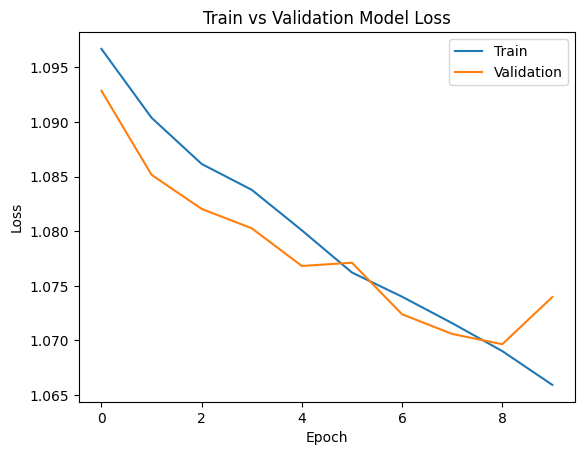

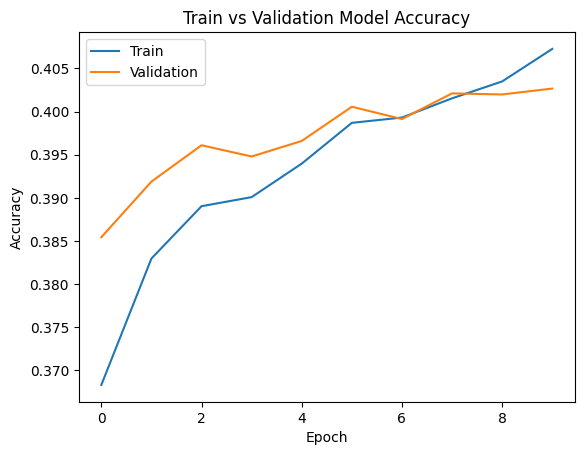


Calculating metrics...
Accuracy: 0.4032504780114723
Precision: [0.41363926 0.39362149 0.4084507 ]
Recall: [0.37213303 0.53784404 0.29965557]
F1 score: [0.39178992 0.45456748 0.34569536]
Support: [1744 1744 1742]
              precision    recall  f1-score   support

           0       0.41      0.37      0.39      1744
           1       0.39      0.54      0.45      1744
           2       0.41      0.30      0.35      1742

    accuracy                           0.40      5230
   macro avg       0.41      0.40      0.40      5230
weighted avg       0.41      0.40      0.40      5230



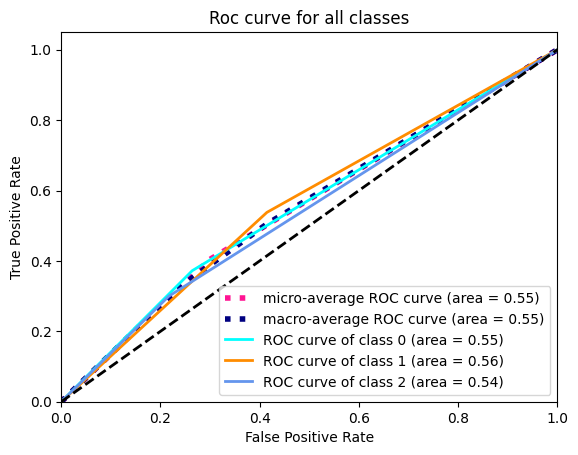

In [30]:
trained_model_attention=train_evaluate_bidirectional_RNN_model_ATTENTION(TEXT, train_data, valid_data)

#Predictions for submission

Preprocess test data

In [31]:
def get_text(dataframe, text_column, stopwords_file):

    # Apply the pre-processing function to the text column
    dataframe[text_column] = dataframe[text_column].apply(preprocess_text, stopwords_file=stopwords_file)
    print('\nText done pre-processing!')

    return dataframe[text_column]

In [32]:
test=pd.read_csv('/kaggle/input/ys19-2023-assignment-3/test_set.csv',encoding='utf-8')
# Preprocess and resample dataset and return a new cleaned one
test_dataframe = get_text(test, 'Text',stopwords_file=stopwords_file)


Text done pre-processing!


Dynamically load trained model

In [33]:
import os

# Check if GRU model file exists
if os.path.exists('GRU_ATTENTION_model.pt'):
    trained_model_attention.load_state_dict(torch.load('GRU_ATTENTION_model.pt'))
    print("GRU+attention model loaded.")
# Check if LSTM model file exists
elif os.path.exists('LSTM_ATTENTION_model.pt'):
    trained_model_attention.load_state_dict(torch.load('LSTM_ATTENTION_model.pt'))
    print("LSTM+attention model loaded.")
else:
    print("No trained model file found.")

LSTM+attention model loaded.


In [34]:
nlp = spacy.blank("el")
def predict_sentiment_labels(model, sentences, label_vocab):
    model.eval()
    predictions = []
    for sentence in sentences:
        if isinstance(sentence, str) and sentence.strip() == "":
            # If the sentence is an empty string, assign polarity as neutral (0)
            predictions.append("0")
        else:
            tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
            indexed = [TEXT.vocab.stoi[t] for t in tokenized]
            length = [len(indexed)]
            tensor = torch.LongTensor(indexed).to(device)
            tensor = tensor.unsqueeze(1)
            length_tensor = torch.LongTensor(length)
            prediction_index = torch.argmax(model(tensor, length_tensor)).item()
            predicted_label = label_vocab[prediction_index]
            predictions.append(predicted_label)
    return predictions

predictions = predict_sentiment_labels(trained_model_attention, test['Text'], LABEL.vocab.itos)
#we use the argmax to get the highest predicted class index. We then use this index with the label vocab to get 
#the actual label "1","2","0" and then map it to the human readable label "POSITIVE","NEGATIVE","NEUTRAL".


In [35]:
len(predictions)

10470

In [36]:
mapping = {"0": 'NEUTRAL', "1": 'POSITIVE', "2": 'NEGATIVE'}
y_categorical = [mapping[value] for value in predictions]
# Print the result
#print(y_categorical)

In [37]:
my_submission = pd.DataFrame({'Id': test.New_ID, 'Predicted': y_categorical})
my_submission.to_csv('submission-lt12200010.csv', index=False)

In [38]:
df=pd.read_csv('submission-lt12200010.csv')
# Check the distribution of classes
distribution = df['Predicted'].value_counts()/df.shape[0]
print('Distribution of data in classes:')
print(distribution)

Distribution of data in classes:
Predicted
NEGATIVE    0.628176
POSITIVE    0.340210
NEUTRAL     0.031614
Name: count, dtype: float64
